In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("incl/")

import noror

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
trajectories = noror.utils.load_trajectories(filename='../trajectories_n_kmax=200.npz')
derivs = noror.utils.load_trajectories(filename='../derivs_n_kmax=200.npz')


ind = 1

trajectories = trajectories[::ind]
derivs = derivs[::ind]

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


cutoff = int(n_trajectories*0.9)

train_trajectories = trajectories[:cutoff]
train_derivs = derivs[:cutoff]

test_trajectories = trajectories[cutoff:]
test_derivs = derivs[cutoff:]


1000 loaded with n_kmax = 200


In [63]:
dim_reducer = noror.dim_reducers.SVD()
scaler = noror.scalers.standardize_scaler(1.0)
transformer = noror.transformers.ELM_features(ELM_nodes=400)
optimizer = noror.optimizers.ridge(alpha=10.**-0)

model = noror.noror(train_trajectories, train_derivs, rdim=20, VAR_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    VAR_transformer=transformer)

model.train()

model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  20
VAR_l:  2
train shape:  (360000, 441)
target shape:  (360000, 200)
weights shape:  (441, 200)


In [64]:
ind = 0

test_trajectory = test_trajectories[ind]
truth = test_derivs[ind]

pred = model.predict(test_trajectory)

print( model.get_error(test_trajectory,truth,pred,norm='NF') ) 
print( model.get_error(test_trajectory,truth,norm='NF') ) 
print( model.get_error(truth=truth, pred=pred, norm='max') ) 

2.7775944506421443e-05
2.7775944506421443e-05
0.0004153729334641955


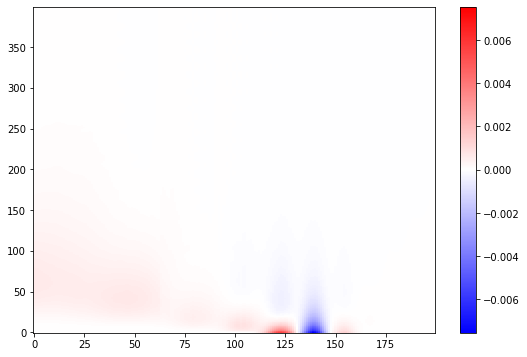

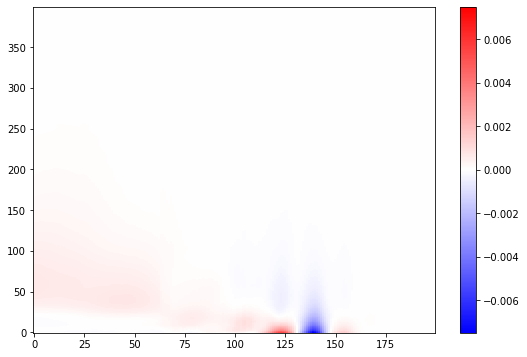

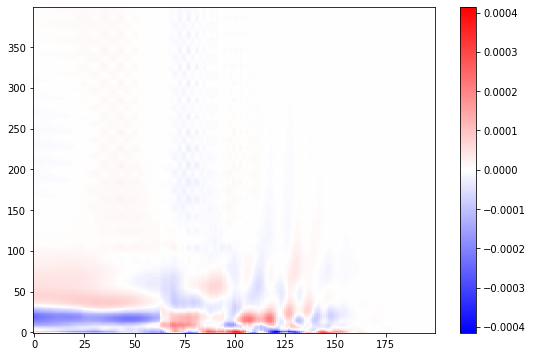

In [65]:
import matplotlib.colors as colors

plt.imshow(truth, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

plt.imshow(pred, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()


plt.imshow(pred-truth, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()


In [61]:
dim_reducer = noror.dim_reducers.SVD()
scaler = noror.scalers.standardize_scaler(1.0)
transformer = noror.transformers.ELM_features(ELM_nodes=400)
optimizer = noror.optimizers.ridge(alpha=10.**0)

model = noror.noror(rdim=20, VAR_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    VAR_transformer=transformer)


scores = noror.utils.get_KFold_CV_scores(model, trajectories, derivs, folds=10, seed=817,
                                          norms=['NF','max'],
                                          train_kwargs={})

print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

NF error:  3.653616790927599e-05 +- 1.7151520099665652e-05
max error:  0.0007940724680101079 +- 0.0005944941905418792


NF error:  2.3865438361803853e-05 +- 1.3784031088903928e-05
max error:  0.0005406501694934073 +- 0.00045588141922440356


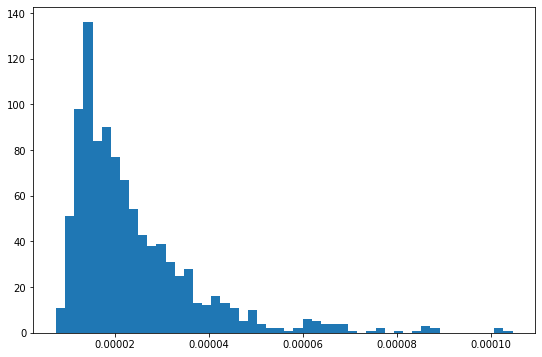

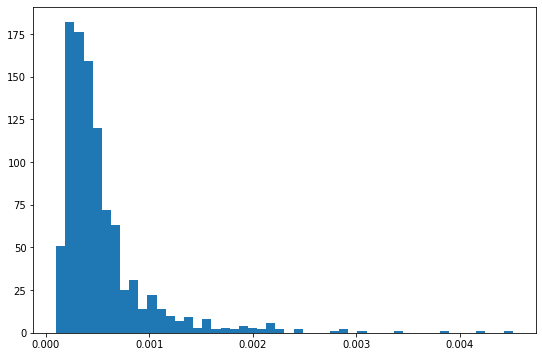

In [58]:
print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

plt.hist(scores[0],bins=50)
plt.show()

plt.hist(scores[1],bins=50)
plt.show()

In [42]:
from ivp_integrator import ivp_integrator

In [66]:
integrator = ivp_integrator(model, dt=1.0, dt_out=5., method='Euler')

NF error: 0.03827269082753234
max error: 0.09006223935811497


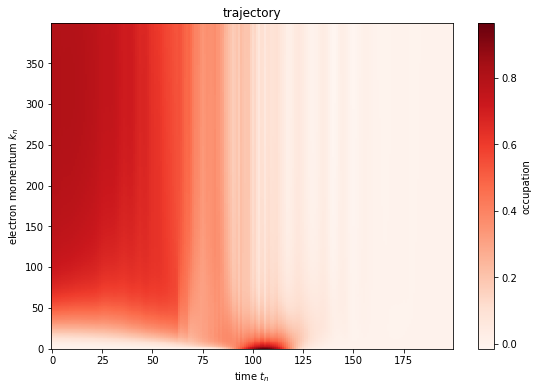

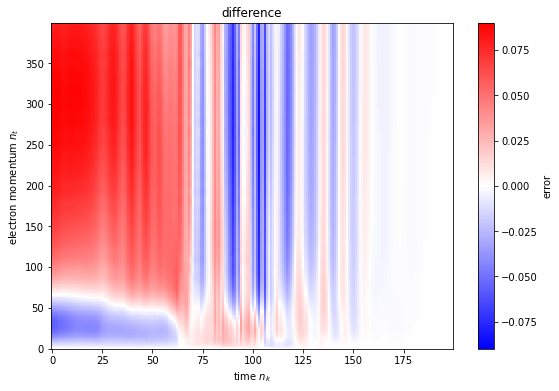

In [67]:
test_trajectory = test_trajectories[3]


pred = integrator.integrate(test_trajectory,test_trajectory.shape[0])


print('NF error:', integrator.get_error(test_trajectory,pred, norm='NF'))
print('max error:', integrator.get_error(test_trajectory,pred, norm='max'))


noror.utils.plot_trajectory(pred)

noror.utils.plot_difference(truth=test_trajectory,test=pred)


In [11]:
dim_reducer = noror.dim_reducers.SVD()
scaler = noror.scalers.standardize_scaler(1.0)
transformer = noror.transformers.ELM_features(ELM_nodes=400)
optimizer = noror.optimizers.ridge(alpha=10.**-3)

model = noror.noror(rdim=50, VAR_l=1, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    VAR_transformer=transformer)


integrator = integrator = AI_integrator(model, dt=1., dt_out=5.)


scores = noror.utils.get_KFold_CV_scores(integrator, trajectories, derivs, folds=10, seed=817,
                                          norms=['NF','max'],
                                          train_kwargs={})

print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

NF error:  0.01729726764841045 +- 0.00992209395779122
max error:  0.07355576434577378 +- 0.04262911405785058


NF error:  0.01729726764841045 +- 0.00992209395779122
max error:  0.07355576434577378 +- 0.04262911405785058


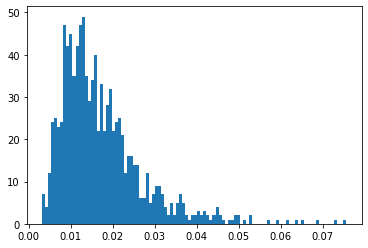

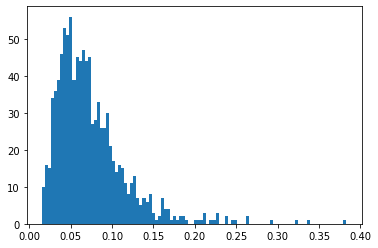

In [12]:
print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

plt.hist(scores[0],bins=100)
plt.show()

plt.hist(scores[1],bins=100)
plt.show()